In [1]:
# coding: utf-8
# a simple MLP network
import time
import numpy as np
import scipy.io as spio
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA


hidden_size=100
output_size=3
batch_size=50
beta = 0.1 # regularization

sess = tf.Session()

In [2]:
def load_data():
    data_dir = "train_test"
    X_train = spio.loadmat(data_dir + "/" + "train_data.mat")["train_data"]
    X_test = spio.loadmat(data_dir + "/" + "test_data.mat")["test_data"]
    y_train = spio.loadmat(data_dir + "/" + "train_label.mat")["train_label"]
    y_test = spio.loadmat(data_dir + "/" + "test_label.mat")["test_label"]
    return X_train, X_test, y_train, y_test

In [3]:
def normalize(X):
    mean = X.mean(axis=0)
    var = X.std(axis=0)
    return (X - mean) / var, mean, var

In [4]:
def visual_2D(X, y):
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)
    
    # plot 
    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    target_names = ["-1", "0", "1"]
    for color, i, target_name in zip(colors, [-1, 0, 1], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Input dataset')
    plt.show()

In [5]:
def lb2vec(y_in):
    y = y_in.ravel()
    a = y - y.min()
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

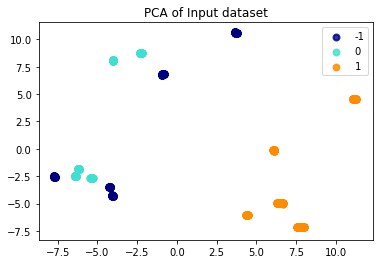

In [6]:
X_train, X_test, y_train_lb, y_test_lb = load_data()

X_train.dump("out/X_train.np")
X_test.dump("out/X_test.np")
y_train_lb.dump("out/y_train.np")
y_test_lb.dump("out/y_test.np")

# visualize original data in 2D
visual_2D(np.vstack((X_train, X_test)),np.vstack((y_train_lb,y_test_lb)).flatten())

In [7]:
X_train, X_train_mean, X_train_var = normalize(X_train)
# X_test = normalize(X_test)
X_test = (X_test - X_train_mean) / X_train_var
# map y labels to one-hot format
y_train = lb2vec(y_train_lb)
y_test = lb2vec(y_test_lb)

In [8]:
# MLP model
def mlp_model(input_layer, hidden_size=hidden_size):
    W1 = tf.Variable(tf.random_normal([310, hidden_size], mean=0.0, stddev=1.0))
    b1 = tf.Variable(tf.random_normal([1, hidden_size], mean=0.0, stddev=1.0))
    hidden_layer = tf.nn.relu(tf.matmul(input_layer, W1) + b1)
    W2 = tf.Variable(tf.random_normal([hidden_size, output_size], mean=0.0, stddev=1.0))
    b2 = tf.Variable(tf.random_normal([1, output_size], mean=0.0, stddev=1.0))
    output_layer = tf.matmul(hidden_layer, W2) + b2
    
    regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(b2)
    return output_layer, regularizer

# pipeline
input_layer = tf.placeholder(tf.float32, shape=(None, 310))
y_label = tf.placeholder(tf.float32, shape=(None, output_size))
output_layer, regularizer = mlp_model(input_layer)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y_label)) + beta * regularizer

# opt = tf.train.AdadeltaOptimizer(0.1)
opt = tf.train.GradientDescentOptimizer(0.05)
train_step = opt.minimize(loss)

In [9]:
# Accuracy
y_predict = tf.nn.softmax(output_layer)
correct_prediction = tf.equal(tf.argmax(y_predict, axis=1), tf.argmax(y_label, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
# sess.run(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y_label), feed_dict={input_layer: X_train, y_label: y_train})

In [11]:
# sess.run(b1, feed_dict={input_layer: X_test, y_label: y_test})

In [12]:
# sess.run(loss, feed_dict={input_layer: X_test, y_label: y_test})

In [13]:
# Train, mini-batch processing
def train():
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(1000):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        rand_x = X_train[rand_index]
        rand_y = y_train[rand_index]
        train_dict = {input_layer: rand_x, y_label: rand_y}
        test_dict = {input_layer: X_test, y_label: y_test}
        sess.run(train_step, feed_dict=train_dict)
        if (i+1)% 25 == 0:
            print('Step #' + str(i+1))
            print('Train loss = ' + str(sess.run(loss, feed_dict=train_dict)))
            print('Test loss = ' + str(sess.run(loss, feed_dict=test_dict)))
            print('Accuracy(Test) = ' + str(sess.run(accuracy, feed_dict=test_dict)))
            
    return float(sess.run(accuracy, feed_dict=test_dict))
        
    

In [14]:
loss_list = []
time_list = []

for iters in range(10):
    print iters
    start_time = time.time()
    loss_list.append(train())
    end_time = time.time()
    time_list.append(end_time-start_time)

0
Step #25
Train loss = 1216.57
Test loss = 1244.27
Accuracy(Test) = 0.492711
Step #50
Train loss = 946.875
Test loss = 968.41
Accuracy(Test) = 0.492711
Step #75
Train loss = 736.963
Test loss = 753.698
Accuracy(Test) = 0.492711
Step #100
Train loss = 573.589
Test loss = 586.593
Accuracy(Test) = 0.492711
Step #125
Train loss = 446.431
Test loss = 456.539
Accuracy(Test) = 0.492711
Step #150
Train loss = 347.463
Test loss = 355.319
Accuracy(Test) = 0.492711
Step #175
Train loss = 270.436
Test loss = 276.539
Accuracy(Test) = 0.48688
Step #200
Train loss = 210.484
Test loss = 215.223
Accuracy(Test) = 0.38484
Step #225
Train loss = 163.823
Test loss = 167.542
Accuracy(Test) = 0.344023
Step #250
Train loss = 127.508
Test loss = 130.477
Accuracy(Test) = 0.51312
Step #275
Train loss = 99.2452
Test loss = 101.641
Accuracy(Test) = 0.51312
Step #300
Train loss = 77.2493
Test loss = 79.1924
Accuracy(Test) = 0.51312
Step #325
Train loss = 60.134
Test loss = 61.7414
Accuracy(Test) = 0.580175
Step #3

In [15]:
print "Average accuracy on test set(hidden_size=100): ", sum(loss_list) / len(loss_list)

Average accuracy on test set(hidden_size=100):  0.830903768539


In [ ]:
print "Average accuracy on test set(hidden_size=10): ", sum(loss_list) / len(loss_list)

In [ ]:
print "Average accuracy on test set(hidden_size=1): ", sum(loss_list) / len(loss_list)

In [16]:
print "Average time cost: ", sum(time_list) / 10.0

Average time cost:  2.24938123226
